In [3]:
import json
import math
import csv

# with open('dataset1022.json' , 'r') as reader:
#     jf = json.loads(reader.read())
# num_data = len(jf)

# with open('segment1209_keywords.json' , 'r') as reader:
#     Seg = json.loads(reader.read())
# num_seg = len(Seg)

# with open('segment1209_stopwords.json' , 'r') as reader:
#     Seg_stop = json.loads(reader.read())
# num_seg_stop = len(Seg)

with open('four_type1215.json' , 'r') as reader:
    art_type4 = json.loads(reader.read())  # art_type['id']=0/1/2/3

with open('twelve_type1215.json' , 'r') as reader:
    art_type12 = json.loads(reader.read())  # art_type['id']=0/1/2/3

emotion = {}
with open('cvaw4.csv', newline='') as csvfile:
    rows = csv.DictReader(csvfile)
    for row in rows:
        emotion[row['Word']] = (row['Arousal_Mean'])

print (num_data)
print(num_seg)
print (num_seg_stop)

20937
20937
20937


In [24]:
import json
import math
import csv

with open('dataset0730.json' , 'r') as reader:
    jf = json.loads(reader.read())
num_data = len(jf)

with open('segment0730_keywords.json' , 'r') as reader:
    Seg = json.loads(reader.read())
num_seg = len(Seg)

with open('segment0730_stopwords.json' , 'r') as reader:
    Seg_stop = json.loads(reader.read())
num_seg_stop = len(Seg)

with open('four_type0225.json' , 'r') as reader:
    art_type4 = json.loads(reader.read())  # art_type['id']=0/1/2/3
    
with open('crush0228_4.json' , 'r') as reader:
    crush = json.loads(reader.read())
    
emotion_a = {}
emotion_v = {}
with open('cvaw4.csv', newline='') as csvfile:
    rows = csv.DictReader(csvfile)
    for row in rows:
        emotion_a[row['Word']] = (row['Arousal_Mean'])
        emotion_v[row['Word']] = (row['Valence_Mean'])
        
print (num_data)
print(num_seg)
print (num_seg_stop)

20963
20963
20963


In [48]:
# 找出可辨識星象的文章、且長度足夠(>20個詞)的文章 ,出來是 a list of id
temp = list(set(art_type4.keys()) & set(Seg))
useable = []
usb_4 = [0,0,0,0]
# usb_12 = [0,0,0,0,0,0,0,0,0,0,0,0]
for i in temp:
    useable.append(i)
    usb_4[art_type4[i]]+=1
print ('useable: ', len(useable))
print (usb_4)

useable:  7477
[1832, 1758, 2091, 1796]


tf: 該詞在檔案中的出現次數/所有字詞的出現次數之和。<br>
idf: 總檔案數目除以包含該詞語之檔案的數目，再將得到的商取以10為底的對數得到

# 性別

In [26]:
def Gender():
    vec_gen = {}
    male = 0
    m = [0,0,0,0]
    f = [0,0,0,0]
    for ID in jf:
        # ID = str(jf['id'])
        if ID in useable:
            if jf[ID]['gender']=='F':
                vec_gen[ID] = 1
                f[ art_type4[ID] ] += 1
            elif jf[ID]['gender']=='M':
                vec_gen[ID] = -1
                m[ art_type4[ID] ] += 1
                male += 1
            else:
                vec_gen[ID] = 0
    female = len(useable)-male
    print ('all:{}'.format(len(useable)),'male:{}'.format(male),'female:{}'.format(female))
    print ('m:', m)
    print ('f:', f)
    return vec_gen

vec_gender = Gender()

all:7477 male:1905 female:5572
m: [484, 414, 583, 424]
f: [1348, 1344, 1508, 1372]


# 發文時間向量

In [28]:
from datetime import date
import re
import pandas as pd

def activeTime(item): # (owl, busy, free)=(0,1,2)
    vec_time = {}
    # for a in range(num_data):
    for ID in jf:
        # ID = str(jf[a]['id'])
        if ID in useable:
            output = re.findall(r'(\d*)-(\d*)-(\d*)T(\d*):(\d*):(\d*)', jf[ID][item])
            # print (output[0])
            time = output[0]
            hour = int(time[3])
            # night owl
            if (hour>=1 and hour<7): 
                vec_time[ID] = 0  
            else:
                wkd = date(int(time[0]), int(time[1]), int(time[2])).weekday()
                # busy
                if (wkd>=1 and wkd<=5) and ((hour>=9 and hour<12) or (hour>=14 and hour<17)):
                    vec_time[ID] = 1                  
                # free
                else: 
                    vec_time[ID] = 2
    return vec_time


# after onehot-encoding, there are 6 dimensions
def encodeTime():
    vec_createTime = activeTime("createdAt")
    vec_updateTime = activeTime("updatedAt")
    vec_time = {}
    
    for ID in useable:
        ohe = [0,0,0,0,0,0]
        ohe[ vec_createTime[ID] ]+=1
        ohe[ vec_updateTime[ID]+3 ]+=1    
        vec_time[ID] = ohe
    return vec_time

vec_time = encodeTime()

# 文章字數向量

In [29]:
def countArtLen(): # count an article's length
    vec_artlen = {}
    # for a in range(num_data):
    for ID in jf:
        # ID = str(jf[a]['id'])
        if ID in useable:
            content = jf[ID]['content']
            vec_artlen[ID] = len(content)
    return vec_artlen

vec_artlen = countArtLen()

# 句子平均長度向量

In [30]:
import re
def countSenLen():
    vec_sentence_len = {}
    # for a in range(num_data):
    for ID in jf:
        # ID = str(jf[a]['id'])
        if ID in useable:
            content = jf[ID]['content']
            holder = re.split(',|\?| |\(|\)|\.|!|，|。|、|\n|：|；|？|…|⋯|（|）|！|～',content)
            num_sen = 0
            total = 0
            for one_sen in holder:
                if len(one_sen)>0:
                    num_sen += 1
                    total += len(one_sen)
            vec_sentence_len[ID] = total/num_sen   

    return vec_sentence_len

vec_senlen = countSenLen()

# 感嘆詞

In [31]:
def countSigh(): # count sigh words number
    # ask, shock, sad, jolly
    sigh = [['嗎', '呢', '咦', '蛤'], ['啊', '喔', '哦', '吧', '吶', '呦', '啦', '囉'], ['嗚', '哎', '噢', '唉', '呀'], ['嘿', '哈', '呵', '嘻']]
    # sigh = ['哈','呵','嘻','呢','嗎','咦','喔','呦','嗯','啊','呀','吶','噢','嗚','哎','哇','蛤']
    vec_sigh = {}
    # for a in range(num_data):
    for ID in jf:
        # ID = str(jf[a]['id'])
        if ID in useable:
            num_sigh = [0, 0, 0, 0]
            # num_sigh = 0
            for s in range(len(sigh)):
                for w in sigh[s]:
                    num_sigh[s] += jf[ID]['content'].count(w)
                num_sigh[s] = num_sigh[s]/len(jf[ID]['content'])            
            vec_sigh[ID] = num_sigh 

    return vec_sigh

vec_sigh = countSigh()

# 表情符號

In [32]:
from emoji import UNICODE_EMOJI

def emojis(s):
    count = 0
    for emoji in UNICODE_EMOJI:
        count += s.count(emoji)
    return count

def countEmoji(): # count sigh words number
    vec_emoji = {}
    # for a in range(num_data):
    for ID in jf:
        # ID = str(jf[a]['id'])
        if ID in useable:
            content = jf[ID]['content']
            vec_emoji[ID] = emojis(content)/len(content)
    return vec_emoji

vec_emoji = countEmoji()

# 標點符號

In [33]:
def Punctuation():
    vec_punc = {}
    puncs = [',','，',':','：','?','？','!','！','(','（']
    # for a in range(num_data):
    for ID in jf:
        # ID = str(jf[a]['id'])
        if ID in useable:
            content = jf[ID]['content']           
            puncArray = [0,0,0,0,0]
            for i in range(5):
                puncArray[i] += content.count(puncs[(i*2)])
                puncArray[i] += content.count(puncs[(i*2+1)])
            
            for i in range(5):
                puncArray[i] = puncArray[i]/len(content)                
            vec_punc[ID] = puncArray
    return vec_punc

vec_punc = Punctuation()

# 人稱

In [34]:
def PersonalPronoun(): # 我們、我、你妳、他她
    vec_pp = {}
    # for a in range(num_data):
    for ID in jf:
        # ID = str(jf[a]['id'])
        if ID in useable:
            content = jf[ID]['content']
            holder = re.split(',|\?| |\(|\)|\.|!|，|。|、|\n|：|；|？|…|⋯|（|）|！|～',content)
            
            ppArray = [0,0,0,0]
            for one_sen in holder:
                if len(one_sen)>=2:
                    if one_sen[0]=='我':
                        if one_sen[1]=='們':
                            ppArray[0]+=1
                        else:
                            ppArray[1]+=1
                    elif one_sen[0]=='你' or one_sen[0]=='妳':
                        ppArray[2]+=1
                    elif one_sen[0]=='他' or one_sen[0]=='她':
                        ppArray[3]+=1
            for i in range(4):
                ppArray[i] = ppArray[i]/len(content)
            vec_pp[ID] = ppArray   

    return vec_pp

vec_pp = PersonalPronoun()

# 情緒詞

In [35]:
level_1=0
level_2=0
level_3=0
for w in emotion_a:
    emotion_v[w] = float(emotion_v[w])
    if emotion_v[w]<4.0:
        level_1+=1
    elif emotion_v[w]<6.0:
        level_2+=1
    else:
        level_3+=1
print ('level_1:',level_1, '|level_2:',level_2, '|level_3:',level_3)

level_1: 2554 |level_2: 1474 |level_3: 1484


In [36]:
import math
def FindEmotionWords():
    vec_emotion={}
    for ID in useable:
        valance = [0,0,0]     #[bad, peace, happy]
        emo_count = 0
        for w in Seg[ID]:
            if w in emotion_v.keys():
                emo_count += 1
                v = float(emotion_v[w])
                a = float(emotion_a[w])
                if v<4.0:
                    valance[0] += (4-v)*math.log(a, 1.5)
                elif v<6.0:
                    valance[1] += 1.5*math.log(a, 1.5)
                else:
                    valance[2] += (v-6)*math.log(a, 1.5)
        if emo_count!=0:
            for i in range(3):
                valance[i] /= emo_count
                valance[i] = round(valance[i], 3)
        vec_emotion[ID] = valance
    return vec_emotion
                
vec_emotion = FindEmotionWords()

In [242]:
for ID in useable:
    if vec_artlen[ID]>150 and vec_artlen[ID]<300 and vec_emotion[ID][2]>2 and ('有夠' in jf[ID]['content']):
        print (ID)
        EMO = vec_emotion[ID]
        print ('negative= {}, peace= {}, positive= {}'.format(EMO[0], EMO[1], EMO[2]))
        print ('-----')
        print (jf[ID]['content'])
        print ()

232001492
negative= 1.672, peace= 1.323, positive= 2.168
-----
有沒有金牛女成功收服水瓶男的🥺

跟水瓶想處真的有夠痛苦😭😭😭
我自己也很傲，但傲到最後受不了還是自己去密了他（之前被已讀）
再之前很曖昧都會主動報備
之後都是時好時不好 彼此偶爾分享自己在幹嘛而已
但有時候分享了又沒有個回應
我們也很久沒有好好你一句我一句聊天了
雖然他說很忙，我也有要忙的事但我就會掛這一顆心在他那，但他好像也沒有相對的這樣對我
我也不敢跟他講太多搞不好我誤解意思
但之前都會報備的意思是什麼..

230913334
negative= 0.0, peace= 1.819, positive= 2.239
-----
原本想說～今年19在平日
大概不會有人記得吧😭

沒想到蠍蠍學長在生日倒數前十分鐘
把禮物送來我家
感動感動🥰🥰

最近看到很多魚女蠍男的組合
真的！他們有夠虐人的（大白目
送禮物前還把我惹生氣，結果讓我從心情-100飆到100😂

僅祝所有319的魚尾巴們生日快樂～～～
還有所有蠍眷們幸福快樂

#附圖是禮物熊熊🥰
https://i.imgur.com/ikH4LKl.jpg
#更
因為讀夜校所以到十點才下課
嗯⋯一下樓，就被泡泡好好的疼愛了
https://i.imgur.com/vi9t21X.jpg

231336115
negative= 0.193, peace= 0.687, positive= 3.576
-----
「愛你是孤單的心事，
    不懂你微笑的意思，
    只能像一朵向日葵，
    在夜裡默默的堅持。」



靠邀
到底喜不喜歡嘛
一下很暖很貼心一下又愛嗆我愛跟我提別的女生
不喜歡就不要買宵夜到我家給我
不喜歡就不要還特地偷偷準備幫我慶生
不喜歡就不要每天跟我聊天哄我到睡著
不喜歡就不要總是鬧我我總是贏不過你
不喜歡就不要讓我想著你的一舉一動想到失眠⋯


擊敗雙子男
但是我好愛
有夠靠邀

好了我發洩完了🌝
—被搞瘋但莫名很爽的牛



In [235]:
# tempid = 4
# EMO = vec_emotion[useable[tempid]]
ID = '230707591'
EMO = vec_emotion[ID]
print ('negative= {}, peace= {}, positive= {}'.format(EMO[0], EMO[1], EMO[2]))
print ('-----')
print (jf[ID]['content'])

negative= 0.397, peace= 0.0, positive= 2.574
-----
雖然很多人都說金牛不吃回頭草
但是我還是想要挽回他！
請大家多多指教一下！

我們是因爲環境因素而導致分開
不是不愛了
和平分開

分了三個月了 沒怎麼聯絡


In [70]:
def FindEmotionWords_arousal():
    # Dict_collector_emotion = []
    vec_emotion={}
    for ID in useable:
        emo_count=0
        level = [0,0,0]     #[ease, normal, excited]
        for w in Seg[ID]:
            if w in emotion_a.keys():
                if float(emotion_a[w])<4:
                    level[0] += 1
                elif float(emotion_a[w])<6:
                    level[1] += 1
                else:
                    level[2] += 1
                emo_count += 1
        if emo_count != 0 :
            level[0] /= emo_count
            level[1] /= emo_count
            level[2] /= emo_count

        vec_emotion[ID]=level
    return vec_emotion
                
vec_emotion_arousal = FindEmotionWords_arousal()

# tag數

In [37]:
def TagNum():
    vec_tag = {}
    for ID in useable:
        vec_tag[ID] = len(jf[ID]['topics'])        
    return vec_tag

vec_tagNum = TagNum()

# 匿名性

In [38]:
def Anonymous():
    vec_ano = {}
    for ID in useable:
        vec_ano[ID] = [int(jf[ID]['anonymousSchool']),int(jf[ID]['anonymousDepartment']),int(jf[ID]['withNickname'])]
    return vec_ano

vec_anonymous = Anonymous()

In [266]:
vec_anonymous[useable[1]]

[0, 1, 0]

# tag到的人

In [39]:
def Crush():
    vec_cr = {}
    for ID in useable:
        dish = [0,0,0,0]
        if ID in crush:
            dish[crush[ID]]+=1
        vec_cr[ID] = dish
    return vec_cr

vec_crush = Crush()

# 詞性統計

# 合併向量

In [ ]:
## 關鍵詞、停用詞、時間1、時間2、感嘆、文長、句長、表情數、情緒詞、人稱、標點

In [258]:
with open('keywords_CKIP_1200.json' , 'r') as reader:
    Key = json.loads(reader.read())
num_k = len(Key)
with open('stopwords_CKIP_200.json' , 'r') as reader:
    Stop = json.loads(reader.read())
num_s = len(Stop)

def BagOfWords(ID):
    for ele in Key[ID]:
        one_vec.append(ele)
    for ele in Stop[ID]:
        one_vec.append(ele)
    return one_vec

# type(k500[useable[0]]) --> list
len(Key[useable[0]])

In [60]:
with open('w2v_key_800.json' , 'r') as reader:
    w2v_key = json.loads(reader.read())
    
with open('w2v_stop_100.json' , 'r') as reader:
    w2v_stop = json.loads(reader.read())    
    
print (len(w2v_key[useable[0]]), len(w2v_stop[useable[0]]))

800 100


In [71]:
# after dimension reduction

def put_features_in_vec(article, stop): 
    V = {}
    for ID in useable:
        if ID not in w2v_key:
            print (ID)
            continue
        # one_vec = bow(ID)  # articles as bag-of-words
        one_vec = article[ID] + [vec_artlen[ID], vec_senlen[ID], vec_emoji[ID], vec_tagNum[ID]]
        one_vec = one_vec + vec_time[ID] + vec_sigh[ID] + vec_emotion[ID] + vec_emotion_arousal[ID] +\
                    vec_pp[ID] + vec_punc[ID] + vec_anonymous[ID] + vec_crush[ID]
        V[ID] = [ID, art_type4[ID]] + one_vec
        
    return V

Vector = put_features_in_vec(w2v_key, w2v_stop)

229969163
231756534


In [73]:
i = useable[0]
print ("Vector lengh:", len(Vector))
print ("Vector features lengh:", len(Vector[i]))
print("w2v_key lengh:", len(w2v_key[i]))
print("w2v_stop lengh:", len(w2v_stop[i]))
print ('4 features with 1 dim')
print(len(vec_time[i]))
print(len(vec_sigh[i]))
print(len(vec_emotion[i]))
print(len(vec_emotion_arousal[i]))
print(len(vec_pp[i]))
print(len(vec_punc[i]))
print(len(vec_anonymous[i]))
print(len(vec_crush[i]))

Vector lengh: 7475
Vector features lengh: 838
w2v_key lengh: 800
w2v_stop lengh: 100
4 features with 1 dim
6
4
3
3
4
5
3
4


## create column list

In [74]:
# def ColumnName(num_key, num_stop):
def ColumnName(article, stop):

    csv_columns = ['ID', 'label']

    for i in range( len(article[useable[0]]) ):
        csv_columns.append('w2v_key_{}'.format(i))
#     for i in range( len(stop[useable[0]]) ):
#         csv_columns.append('w2v_stop_{}'.format(i))        
                
    csv_columns = csv_columns + ['artlen', 'senlen', 'emoji', 'num_tags']
    csv_columns = csv_columns + ['creatT_1', 'creatT_2', 'creatT_3', 'updateT_1', 'updateT_2', 'updateT_3']
    csv_columns = csv_columns + ['sigh_ask', 'sigh_sigh', 'sigh_sad', 'sigh_jolly']
    csv_columns = csv_columns + ['emo_sad', 'emo_peace', 'emo_happy']
    csv_columns = csv_columns + ['emo_low', 'emo_mid', 'emo_high']
    csv_columns = csv_columns + ['we', 'me', 'you', 'him']
    csv_columns = csv_columns + ['comma', 'colon', 'question', 'exclaim', 'bracket']
    csv_columns = csv_columns + ['ano_1', 'ano_2', 'ano_3']
    csv_columns = csv_columns + ['crush_1', 'crush_2', 'crush_3', 'crush_4']
    
    print(len(csv_columns))
    return csv_columns

Cname = ColumnName(w2v_key, w2v_stop)

838


In [75]:
final_Vec_M = []
final_Vec_F = []
for k,v in Vector.items():
    if jf[k]['gender'] == 'M':
        final_Vec_M.append(v)
    else:
        final_Vec_F.append(v)

In [76]:
df = pd.DataFrame(final_Vec_M, columns = Cname) 
df.to_csv('ReadyM_w2v_0731.csv', index=False)


df = pd.DataFrame(final_Vec_F, columns = Cname) 
df.to_csv('ReadyF_w2v_0731.csv', index=False)

In [358]:
len(final_Vec_F[0])

535

In [34]:
from tqdm import tqdm


final_list = []
for k, v in tqdm(Vector.items()):
    print(k)
    # print(v)
    final_list.append([k] + v)
    print (final_list)
    #break

  0%|          | 15/7498 [00:00<00:50, 149.15it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 28/7498 [00:00<01:39, 75.40it/s] IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  1%|          | 38/7498 [00:00<02:39, 46.68it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_

  2%|▏         | 134/7498 [00:07<12:53,  9.52it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  2%|▏         | 136/7498 [00:07<15:04,  8.14it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  2%|▏         | 139/7498 [00:08<14:29,  8.46it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  2%|▏         | 186/7498 [00:14<16:59,  7.17it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  3%|▎         | 189/7498 [00:14<17:13,  7.07it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  3%|▎         | 192/7498 [00:15<17:36,  6.91it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  3%|▎         | 236/7498 [00:23<23:03,  5.25it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  3%|▎         | 239/7498 [00:23<22:10,  5.46it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  3%|▎         | 242/7498 [00:24<22:37,  5.35it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  4%|▍         | 288/7498 [00:35<29:43,  4.04it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  4%|▍         | 289/7498 [00:35<31:22,  3.83it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  4%|▍         | 291/7498 [00:35<30:10,  3.98it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  4%|▍         | 319/7498 [00:43<34:27,  3.47it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  4%|▍         | 320/7498 [00:43<33:34,  3.56it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  4%|▍         | 321/7498 [00:43<33:35,  3.56it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  5%|▍         | 351/7498 [00:52<34:45,  3.43it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  5%|▍         | 352/7498 [00:52<35:36,  3.35it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  5%|▍         | 353/7498 [00:52<35:17,  3.37it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  5%|▌         | 380/7498 [01:00<35:30,  3.34it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  5%|▌         | 381/7498 [01:01<33:57,  3.49it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  5%|▌         | 382/7498 [01:01<38:39,  3.07it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub


232464865


  5%|▌         | 408/7498 [01:10<40:42,  2.90it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  5%|▌         | 409/7498 [01:10<39:32,  2.99it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  5%|▌         | 410/7498 [01:10<39:23,  3.00it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  6%|▌         | 434/7498 [01:19<43:11,  2.73it/s]


232612940


  6%|▌         | 435/7498 [01:19<41:52,  2.81it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▌         | 436/7498 [01:19<40:50,  2.88it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▌         | 437/7498 [01:20<41:11,  2.86it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub


230754446


  6%|▌         | 444/7498 [01:22<42:28,  2.77it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▌         | 446/7498 [01:23<39:56,  2.94it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▌         | 447/7498 [01:23<38:25,  3.06it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  6%|▋         | 476/7498 [01:34<45:19,  2.58it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▋         | 477/7498 [01:35<45:11,  2.59it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▋         | 479/7498 [01:35<43:20,  2.70it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  7%|▋         | 504/7498 [01:45<48:02,  2.43it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  7%|▋         | 506/7498 [01:46<46:43,  2.49it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  7%|▋         | 507/7498 [01:47<47:58,  2.43it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  7%|▋         | 533/7498 [01:58<49:34,  2.34it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  7%|▋         | 535/7498 [01:58<48:16,  2.40it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  7%|▋         | 536/7498 [01:59<49:40,  2.34it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  7%|▋         | 562/7498 [02:10<53:44,  2.15it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 564/7498 [02:11<50:00,  2.31it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 565/7498 [02:12<51:36,  2.24it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  8%|▊         | 590/7498 [02:23<55:22,  2.08it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 592/7498 [02:24<52:48,  2.18it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 593/7498 [02:25<54:37,  2.11it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

  8%|▊         | 620/7498 [02:38<57:25,  2.00it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 621/7498 [02:39<59:15,  1.93it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 622/7498 [02:39<55:46,  2.05it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub


231655546


  8%|▊         | 634/7498 [02:46<1:05:05,  1.76it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 636/7498 [02:47<59:09,  1.93it/s]  IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 637/7498 [02:47<1:00:29,  1.89it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

  9%|▉         | 664/7498 [03:01<57:56,  1.97it/s]  IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  9%|▉         | 665/7498 [03:02<1:03:06,  1.80it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  9%|▉         | 667/7498 [03:03<1:02:55,  1.81it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

  9%|▉         | 695/7498 [03:19<1:05:35,  1.73it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  9%|▉         | 696/7498 [03:20<1:04:16,  1.76it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  9%|▉         | 698/7498 [03:21<1:01:38,  1.84it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 10%|▉         | 725/7498 [03:36<1:06:01,  1.71it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 10%|▉         | 727/7498 [03:38<1:08:01,  1.66it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 10%|▉         | 728/7498 [03:38<1:10:14,  1.61it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 10%|█         | 755/7498 [03:55<1:11:14,  1.58it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 10%|█         | 756/7498 [03:56<1:07:54,  1.65it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 10%|█         | 758/7498 [03:57<1:07:36,  1.66it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 11%|█         | 788/7498 [04:16<1:07:43,  1.65it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█         | 789/7498 [04:17<1:16:10,  1.47it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█         | 791/7498 [04:18<1:11:55,  1.55it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp


231374896


 11%|█         | 804/7498 [04:27<1:15:22,  1.48it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█         | 805/7498 [04:27<1:12:03,  1.55it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█         | 807/7498 [04:29<1:15:39,  1.47it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 11%|█         | 838/7498 [04:49<1:14:42,  1.49it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█         | 840/7498 [04:50<1:15:03,  1.48it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█         | 841/7498 [04:51<1:16:11,  1.46it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 12%|█▏        | 869/7498 [05:11<1:20:37,  1.37it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 12%|█▏        | 871/7498 [05:12<1:19:47,  1.38it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 12%|█▏        | 872/7498 [05:13<1:20:05,  1.38it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 12%|█▏        | 901/7498 [05:34<1:20:35,  1.36it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 12%|█▏        | 902/7498 [05:35<1:17:31,  1.42it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 12%|█▏        | 904/7498 [05:36<1:18:14,  1.40it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp


229805231


 12%|█▏        | 907/7498 [05:38<1:19:18,  1.39it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 12%|█▏        | 908/7498 [05:39<1:20:38,  1.36it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 12%|█▏        | 909/7498 [05:40<1:19:05,  1.39it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 13%|█▎        | 938/7498 [06:02<1:23:35,  1.31it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 13%|█▎        | 941/7498 [06:04<1:16:34,  1.43it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 13%|█▎        | 943/7498 [06:06<1:24:18,  1.30it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 13%|█▎        | 975/7498 [06:31<1:25:50,  1.27it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 13%|█▎        | 977/7498 [06:33<1:24:17,  1.29it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 13%|█▎        | 979/7498 [06:34<1:23:25,  1.30it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

 13%|█▎        | 1011/7498 [07:00<1:27:45,  1.23it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 13%|█▎        | 1012/7498 [07:01<1:25:56,  1.26it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▎        | 1013/7498 [07:02<1:29:42,  1.20it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 14%|█▍        | 1041/7498 [07:25<1:37:11,  1.11it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 1042/7498 [07:26<1:35:51,  1.12it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 1043/7498 [07:26<1:34:09,  1.14it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


231835353


 14%|█▍        | 1055/7498 [07:36<1:28:31,  1.21it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 1056/7498 [07:37<1:33:19,  1.15it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 1057/7498 [07:38<1:32:59,  1.15it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 14%|█▍        | 1085/7498 [08:02<1:36:07,  1.11it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 1087/7498 [08:04<1:32:59,  1.15it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▍        | 1088/7498 [08:05<1:34:57,  1.12it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 15%|█▍        | 1116/7498 [08:30<1:35:00,  1.12it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▍        | 1117/7498 [08:31<1:40:01,  1.06it/s]


231901750


 15%|█▍        | 1119/7498 [08:33<1:31:19,  1.16it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▍        | 1120/7498 [08:33<1:33:44,  1.13it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▍        | 1121/7498 [08:34<1:36:16,  1.10it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 15%|█▌        | 1151/7498 [09:02<1:35:56,  1.10it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▌        | 1152/7498 [09:03<1:37:46,  1.08it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▌        | 1154/7498 [09:04<1:35:32,  1.11it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 16%|█▌        | 1181/7498 [09:30<1:41:48,  1.03it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 16%|█▌        | 1182/7498 [09:30<1:35:52,  1.10it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 16%|█▌        | 1183/7498 [09:31<1:36:44,  1.09it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 16%|█▌        | 1213/7498 [10:00<1:40:11,  1.05it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 16%|█▌        | 1214/7498 [10:01<1:40:34,  1.04it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 16%|█▌        | 1216/7498 [10:03<1:40:24,  1.04it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 17%|█▋        | 1248/7498 [10:35<1:46:50,  1.03s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 1249/7498 [10:36<1:46:53,  1.03s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 1250/7498 [10:37<1:47:40,  1.03s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230271955


 17%|█▋        | 1261/7498 [10:48<1:51:21,  1.07s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 1262/7498 [10:49<1:45:53,  1.02s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 1263/7498 [10:50<1:49:44,  1.06s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


229874538


 17%|█▋        | 1291/7498 [11:19<1:45:24,  1.02s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 1292/7498 [11:20<1:49:09,  1.06s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 1293/7498 [11:22<1:56:27,  1.13s/it]


229571859


 17%|█▋        | 1296/7498 [11:24<1:40:14,  1.03it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 1297/7498 [11:25<1:37:15,  1.06it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 1299/7498 [11:28<1:51:11,  1.08s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 18%|█▊        | 1325/7498 [11:55<1:48:48,  1.06s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 18%|█▊        | 1326/7498 [11:56<1:49:13,  1.06s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 18%|█▊        | 1329/7498 [11:59<1:42:14,  1.01it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 18%|█▊        | 1359/7498 [12:32<1:45:59,  1.04s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 18%|█▊        | 1361/7498 [12:34<1:53:03,  1.11s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 18%|█▊        | 1362/7498 [12:36<1:55:57,  1.13s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230883359


 18%|█▊        | 1386/7498 [13:02<1:49:11,  1.07s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 19%|█▊        | 1388/7498 [13:05<1:51:55,  1.10s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 19%|█▊        | 1390/7498 [13:07<1:53:45,  1.12s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 19%|█▉        | 1424/7498 [13:45<1:55:41,  1.14s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 19%|█▉        | 1425/7498 [13:46<1:51:01,  1.10s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 19%|█▉        | 1426/7498 [13:47<1:56:42,  1.15s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 19%|█▉        | 1456/7498 [14:21<1:54:52,  1.14s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 19%|█▉        | 1457/7498 [14:23<1:58:17,  1.17s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 19%|█▉        | 1459/7498 [14:25<1:55:35,  1.15s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 20%|█▉        | 1493/7498 [15:06<1:54:00,  1.14s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|█▉        | 1495/7498 [15:08<1:56:05,  1.16s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|█▉        | 1496/7498 [15:09<1:59:29,  1.19s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230969538


 20%|██        | 1502/7498 [15:17<2:04:20,  1.24s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|██        | 1503/7498 [15:18<1:55:48,  1.16s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|██        | 1504/7498 [15:19<2:01:03,  1.21s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 20%|██        | 1535/7498 [15:57<2:02:35,  1.23s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|██        | 1536/7498 [15:58<2:06:14,  1.27s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 21%|██        | 1538/7498 [16:01<2:03:30,  1.24s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 21%|██        | 1569/7498 [16:39<1:56:22,  1.18s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 21%|██        | 1571/7498 [16:42<2:05:03,  1.27s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 21%|██        | 1572/7498 [16:43<2:06:15,  1.28s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 21%|██▏       | 1600/7498 [17:18<2:04:34,  1.27s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 21%|██▏       | 1601/7498 [17:20<2:04:33,  1.27s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 21%|██▏       | 1603/7498 [17:22<2:05:41,  1.28s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 22%|██▏       | 1638/7498 [18:08<2:12:08,  1.35s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 1639/7498 [18:09<2:13:24,  1.37s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 1641/7498 [18:12<2:08:28,  1.32s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 22%|██▏       | 1674/7498 [18:56<2:06:16,  1.30s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 1675/7498 [18:57<1:59:54,  1.24s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 1676/7498 [18:58<2:10:19,  1.34s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230288085


 22%|██▏       | 1685/7498 [19:11<2:15:41,  1.40s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 1687/7498 [19:13<2:06:48,  1.31s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 1689/7498 [19:16<2:08:17,  1.33s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230783929


 23%|██▎       | 1702/7498 [19:34<2:20:29,  1.45s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 1703/7498 [19:35<2:14:22,  1.39s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 1704/7498 [19:37<2:13:27,  1.38s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 23%|██▎       | 1738/7498 [20:23<2:12:14,  1.38s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 1739/7498 [20:24<2:10:02,  1.35s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 1740/7498 [20:26<2:10:18,  1.36s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


229852798


 23%|██▎       | 1756/7498 [20:49<2:28:17,  1.55s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 1757/7498 [20:50<2:28:35,  1.55s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 1760/7498 [20:54<2:11:05,  1.37s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 24%|██▍       | 1794/7498 [21:44<2:23:14,  1.51s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 24%|██▍       | 1795/7498 [21:46<2:27:40,  1.55s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 24%|██▍       | 1797/7498 [21:49<2:26:24,  1.54s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 24%|██▍       | 1833/7498 [22:43<2:26:34,  1.55s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 24%|██▍       | 1835/7498 [22:46<2:25:08,  1.54s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 24%|██▍       | 1836/7498 [22:47<2:25:30,  1.54s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 25%|██▍       | 1870/7498 [23:39<2:27:10,  1.57s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 25%|██▍       | 1872/7498 [23:42<2:24:02,  1.54s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 25%|██▍       | 1873/7498 [23:44<2:27:40,  1.58s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230234903


 25%|██▌       | 1889/7498 [24:08<2:31:28,  1.62s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 25%|██▌       | 1891/7498 [24:11<2:21:42,  1.52s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 25%|██▌       | 1893/7498 [24:14<2:21:04,  1.51s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 26%|██▌       | 1925/7498 [25:04<2:22:35,  1.54s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 1926/7498 [25:05<2:25:17,  1.56s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 1928/7498 [25:09<2:21:56,  1.53s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


232501398


 26%|██▌       | 1937/7498 [25:23<2:20:37,  1.52s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 1939/7498 [25:26<2:22:07,  1.53s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 1940/7498 [25:27<2:14:42,  1.45s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230152245


 26%|██▌       | 1965/7498 [26:08<2:35:27,  1.69s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 1966/7498 [26:09<2:24:05,  1.56s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 1967/7498 [26:11<2:29:38,  1.62s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230860201


 27%|██▋       | 1988/7498 [26:45<2:24:37,  1.57s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 1990/7498 [26:48<2:27:51,  1.61s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 1991/7498 [26:49<2:19:45,  1.52s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


232552975


 27%|██▋       | 1999/7498 [27:03<2:43:32,  1.78s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 2001/7498 [27:06<2:26:33,  1.60s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 2003/7498 [27:09<2:29:55,  1.64s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230065697


 27%|██▋       | 2010/7498 [27:21<2:30:21,  1.64s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 2011/7498 [27:22<2:32:11,  1.66s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 2014/7498 [27:27<2:26:54,  1.61s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 27%|██▋       | 2044/7498 [28:17<2:28:25,  1.63s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 2045/7498 [28:19<2:34:46,  1.70s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 2047/7498 [28:22<2:27:37,  1.62s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 28%|██▊       | 2078/7498 [29:14<2:34:14,  1.71s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 2080/7498 [29:18<2:33:12,  1.70s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 2081/7498 [29:20<2:38:36,  1.76s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 28%|██▊       | 2112/7498 [30:14<2:39:11,  1.77s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 2115/7498 [30:18<2:22:49,  1.59s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 2117/7498 [30:22<2:46:35,  1.86s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


230038680


 29%|██▊       | 2142/7498 [31:06<2:31:57,  1.70s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▊       | 2145/7498 [31:11<2:27:18,  1.65s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▊       | 2146/7498 [31:14<2:40:56,  1.80s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

230083059


 29%|██▊       | 2149/7498 [31:19<2:32:22,  1.71s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▊       | 2152/7498 [31:24<2:26:41,  1.65s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▊       | 2154/7498 [31:28<2:40:58,  1.81s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

230956871


 29%|██▉       | 2169/7498 [31:54<2:31:57,  1.71s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▉       | 2170/7498 [31:56<2:35:12,  1.75s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▉       | 2171/7498 [31:58<2:38:14,  1.78s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 29%|██▉       | 2206/7498 [33:00<2:26:40,  1.66s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▉       | 2207/7498 [33:02<2:45:48,  1.88s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▉       | 2208/7498 [33:04<2:44:10,  1.86s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

 30%|██▉       | 2239/7498 [34:00<2:42:28,  1.85s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 30%|██▉       | 2241/7498 [34:04<2:40:49,  1.84s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 30%|██▉       | 2243/7498 [34:08<2:44:40,  1.88s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook


229839486


 30%|███       | 2253/7498 [34:27<2:34:19,  1.77s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 30%|███       | 2255/7498 [34:30<2:39:13,  1.82s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 30%|███       | 2256/7498 [34:32<2:30:37,  1.72s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

KeyboardInterrupt: 

# scaling

In [55]:
# from sklearn import preprocessing #标准化数据模块

# Data = []
# for ID in useable:
#     Data.append(Vector[ID])

# scaledv = preprocessing.scale(Data)
# print (scaledv.shape)

# final_Vector = {}
# index = 0
# for i in range(len(useable)):
#     final_Vector[useable[i]] = scaledv[i]

# print (len(final_Vector[useable[0]]))

(6542, 794)
794


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


## Make file

### to txt

In [196]:
def makeFile(trainData, trainTarget, testData, testTarget, gender):
    train = open("Train1211_{}.txt".format(gender), "w")
    test = open("Test1211_{}.txt".format(gender), "w")
    
    num_train = trainData.shape[0]
    num_test = testData.shape[0]
    num_feature = trainData.shape[1]
    
    for index in range(num_train):
        temp = []
        temp.append(str(trainTarget[index]))
        for j in range(num_feature):
            indval = str(j+1)+':'+str( trainData[index][j] )
            temp.append(indval)
        string = ' '.join(temp)
        train.write(string)
        train.write('\n')          
    train.close()
    
    for index in range(num_test):
        temp = []
        temp.append(str(testTarget[index]))
        for j in range(num_feature):
            indval = str(j+1)+':'+str( testData[index][j] )
            temp.append(indval)
        string = ' '.join(temp)
        test.write(string)
        test.write('\n')     
    test.close()

    
makeFile(MtrainData, MtrainTarget, MtestData, MtestTarget, 'male')
makeFile(FtrainData, FtrainTarget, FtestData, FtestTarget, 'female')

In [33]:
# def makeFile(V, gender):
#     train = open("Train1206_{}.txt".format(gender), "w")
#     test = open("Test1206_{}.txt".format(gender), "w")
    
#     for ID in useable:
#         temp = []
#         temp.append(str(art_type[ID]))
#         for j in range(len(V[ID])):
#             indval = str(j+1)+':'+str( V[ID][j] )
#             temp.append(indval)
#         string = ' '.join(temp)
#         if vec_gender[ID] == 1:
#             outF.write(string)
#             outF.write('\n')
#         elif vec_gender[ID] == -1:
#             outM.write(string)
#             outM.write('\n')
#     for i in range()
                
#     outF.close()
#     outM.close()

    
# makeFile(final_Vector)

In [141]:
type(final_Vector[useable[0]])

numpy.ndarray

### to csv

In [47]:
import csv

def makeCSVfile(trainData, trainTarget, testData, testTarget, gender):
    num_train = trainData.shape[0]
    num_test = testData.shape[0]
    num_feature = trainData.shape[1]
    num_key = int( (num_feature-22)/11*10 )
    num_stop = int( (num_feature-22)/11 )
    
    csv_columns = []
    for i in range(num_key): # change me !!!!!!!!!!!!!!!!!!!!!!!!
        csv_columns.append('kw_{}'.format(i))
    for i in range(num_stop):  # change me !!!!!!!!!!!!!!!!!!!!!!!!
        csv_columns.append('sw_{}'.format(i))
    csv_columns = csv_columns + ['artlen', 'senlen', 'sigh', 'emoji']
    csv_columns = csv_columns + ['creatT_1', 'creatT_2', 'creatT_3', 'updateT_1', 'updateT_2', 'updateT_3']
    csv_columns = csv_columns + ['emo_low', 'emo_mid', 'emo_high']
    csv_columns = csv_columns + ['we', 'me', 'you', 'him']
    csv_columns = csv_columns + ['comma', 'colon', 'question', 'exclaim', 'bracket']
    print(len(csv_columns))
    
    Train_out = {}
    Train_out['data'] = trainData
    Train_out['target'] = trainTarget
    Train_out['target_names'] = ['earth', 'wind', 'water', 'fire']
    Train_out['feature_names'] = csv_columns

    with open('Train1210_{}.csv'.format(gender), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(csv_columns)
        for i in range(num_train):
            writer.writerow(trainData[i])
            
    with open('Test1210_{}.csv'.format(gender), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(csv_columns)
        for i in range(num_test):
            writer.writerow(testData[i])
            
    return csv_columns       

In [49]:
flist = makeCSVfile(MtrainData, MtrainTarget, MtestData, MtestTarget, 'male')

792


In [408]:
maleTrain = makeCSVfile(MtrainData, MtrainTarget, MtestData, MtestTarget, 'male')
femaleTrain = makeCSVfile(FtrainData, FtrainTarget, FtestData, FtestTarget, 'female')

792
792


In [50]:
maleTrain

NameError: name 'maleTrain' is not defined

In [297]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold

def filtByVar(Data, thr):
    X=np.array(Data)
    #閥值(threshold)為0.16,表示其變異程度低於0.16就會被removed
    variance_x=VarianceThreshold(threshold=thr)
    X_filted = variance_x.fit_transform(X)
    print (X.shape, X_filted.shape)
    return X_filted

In [299]:
filtedDataM = filtByVar(Mdata, 0.2)
filtedDataF = filtByVar(Fdata, 0.2)

(1681, 902) (1681, 902)
(4861, 902) (4861, 902)


In [330]:
def FeatureSelection(Data, Target):
    X = Data
    y = Target
    #只選得分最好的k＝100個features
    X_new=SelectKBest(f_classif, 100).fit_transform(X, y)
    print(X.shape, X_new.shape)
    fit = X_new.fit(X, y)
    features = fit.transform(X)
    
    return X_new, features

In [331]:
selectedM, ftM = FeatureSelection(filtedDataM, Mtarget)
selectedF, ftF = FeatureSelection(filtedDataF, Ftarget)

(1681, 902) (1681, 100)


AttributeError: 'numpy.ndarray' object has no attribute 'fit'

In [446]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

X, y = np.array(Mdata), Mtarget
X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0
)

plt.figure(1)
plt.clf()
TOP = 100

<Figure size 432x288 with 0 Axes>

<BarContainer object of 792 artists>

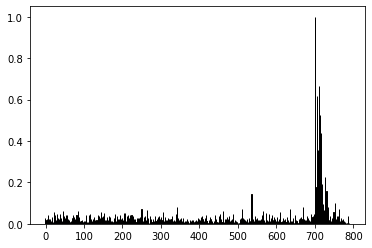

In [447]:
X_indices = np.arange(X.shape[-1])

# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
selector = SelectKBest(f_classif, k=TOP)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')


In [448]:
zip_Score_Feat = []
for i in range(len(scores)):
    temp = (scores[i], maleTrain['feature_names'][i])
    zip_Score_Feat.append(temp)
    
#print (zip_Score_Feat)
zip_Score_Feat.sort(reverse = True)
zip_Score_Feat    

In [449]:
#print (zip_Score_Feat)
zip_Score_Feat.sort()
zip_Score_Feat

[(2.3780904265279422e-05, 'sw_62'),
 (3.5190441812374134e-05, 'question'),
 (4.046713745672567e-05, 'kw_211'),
 (5.981203602441253e-05, 'kw_269'),
 (6.793414046669367e-05, 'kw_527'),
 (7.33748999046183e-05, 'kw_226'),
 (8.208287137618568e-05, 'kw_195'),
 (0.00011781242897206363, 'kw_577'),
 (0.00016389744111324373, 'kw_467'),
 (0.00019656145601326563, 'kw_183'),
 (0.00020017157948907285, 'kw_65'),
 (0.0002989092248181858, 'kw_334'),
 (0.00037072477150764353, 'kw_128'),
 (0.0004262677466764403, 'kw_367'),
 (0.00044145484814790936, 'kw_580'),
 (0.00044419784653525836, 'kw_502'),
 (0.0004460420326125907, 'creatT_2'),
 (0.0004732775356432428, 'kw_531'),
 (0.0004732827322003688, 'kw_380'),
 (0.0004915425401019322, 'sw_66'),
 (0.0005379828384976057, 'colon'),
 (0.0005513719010804048, 'kw_25'),
 (0.0005981000976440697, 'kw_484'),
 (0.0006031155835828035, 'kw_327'),
 (0.0006033757356096518, 'kw_480'),
 (0.0006121947410831403, 'kw_604'),
 (0.0006304975949043262, 'kw_437'),
 (0.00063300476942421

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification accuracy without selecting features: 0.442
Classification accuracy after univariate feature selection: 0.561


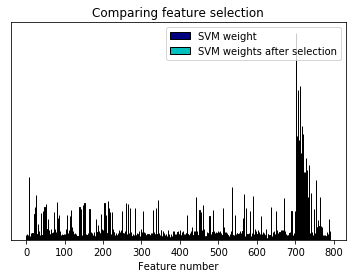

In [450]:
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy', edgecolor='black')

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=TOP), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c',
        edgecolor='black')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [ ]:
100: 471, 552
200: 479, 511
500: 471, 496